In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir(r"E:\CGAN\cropped_sketch"))

['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg', '00011.jpg', '00012.jpg', '00013.jpg', '00014.jpg', '00015.jpg', '00016.jpg', '00017.jpg', '00018.jpg', '00019.jpg', '00020.jpg', '00021.jpg', '00022.jpg', '00023.jpg', '00024.jpg', '00025.jpg', '00026.jpg', '00027.jpg', '00028.jpg', '00029.jpg', '00030.jpg', '00031.jpg', '00032.jpg', '00033.jpg', '00034.jpg', '00035.jpg', '00036.jpg', '00037.jpg', '00038.jpg', '00039.jpg', '00040.jpg', '00041.jpg', '00042.jpg', '00043.jpg', '00044.jpg', '00045.jpg', '00046.jpg', '00047.jpg', '00048.jpg', '00049.jpg', '00050.jpg', '00051.jpg', '00052.jpg', '00053.jpg', '00054.jpg', '00055.jpg', '00056.jpg', '00057.jpg', '00058.jpg', '00059.jpg', '00060.jpg', '00061.jpg', '00062.jpg', '00063.jpg', '00064.jpg', '00065.jpg', '00066.jpg', '00067.jpg', '00068.jpg', '00069.jpg', '00070.jpg', '00071.jpg', '00072.jpg', '00073.jpg', '00074.jpg', '00075.jpg', '00076.jpg', '00077.jpg'

In [13]:
import matplotlib.pyplot as plt # used for ploting results and visulization 
import numpy as np # used for working on matrices operations

import torch # itis the pytorch libraries 
from torch import nn, optim # from pytorch library import nn which is the library in torch used for
#using the neural network layers
#optim is the library used to use the optimization functions such sgd , Adam , momentum

import torch.nn.functional as F # functional library is used  for the same fuctions of nn 
# this is not a classes put functions which provides lower computations also it gives you the ablitiy
# to customize your layers , loss functions , activation functions..etc
#from torch.autograd import Variable
import torch.optim as optim

import torchvision.utils as vutils # used for visulizaing images in grades ...etc
from torchvision import datasets, transforms # the datasets library used for  importing some datasets
# such as mnist , cifer10 
# transfoems library used for  make transformations on the dataset of images 
from torchvision.utils import save_image # then i will use the torchvision .utiles import save_images 
# to save the generated images
# torchvision is alibrary that conatins transform , models , pretained models,visulization techniques

#### Setting parameters

In [14]:
batch_size = 32
image_size = 64

# Learning rate for optimizers
lr = 0.0002

# Number of channels 
channels = 3

# Number of training epochs
epochs = 100

# Latent vector (i.e Size of generator input)
latentVec = 100

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. 0 for cuda mode.
ngpu = 1

# Size of feature maps in generator
FeaGen = 64

# Size of feature maps in discriminator
FeaDis = 64

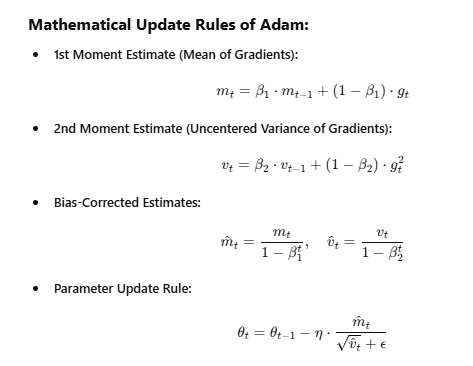

#### Data preparation

In [15]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Decide which device to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crop 64x64 image
image_size = 64
transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize to ensure the smaller dimension is 64
    transforms.CenterCrop(image_size),  # Center crop to 64x64
    transforms.ToTensor(),  # Convert to tensor of normalized values 0-1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Custom Dataset for images with no classes
class CustomImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]  # Include image extensions

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Load dataset
train_data = CustomImageDataset("cropped_sketch", transform=transform)
train_loader = DataLoader(train_data, shuffle=True, batch_size=32)

# Iterate through the data
imgs = next(iter(train_loader))  # Make the dataset iterable
imgs = imgs.numpy().transpose(0, 2, 3, 1)

# Print to check the loaded images
print(imgs.shape)


(32, 64, 64, 3)


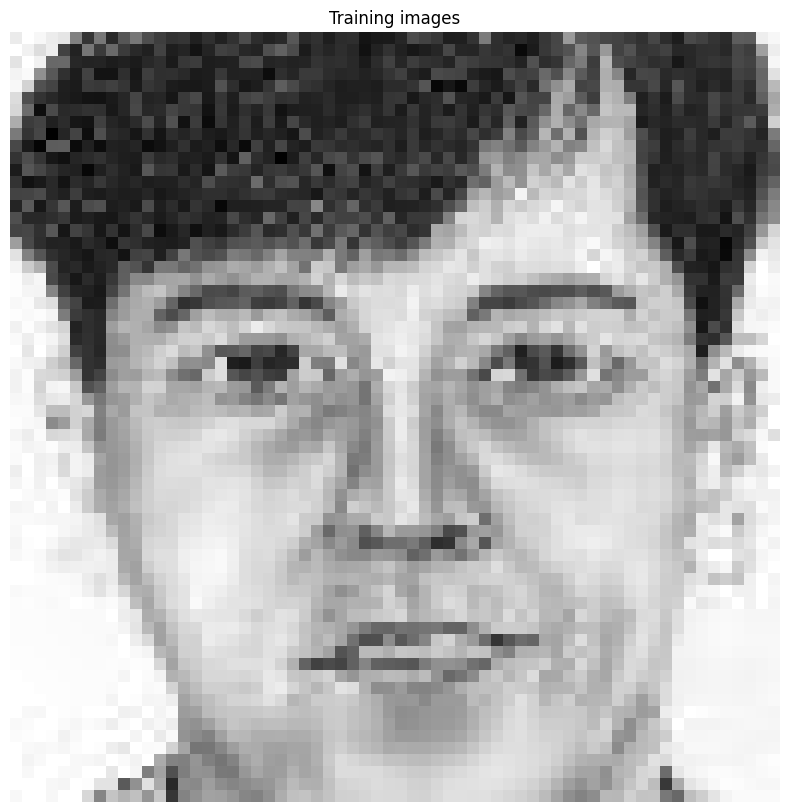

In [16]:
TrainingImages = next(iter(train_loader))
plt.figure(figsize=(12, 10))
plt.axis("off")
plt.title("Training images")
#make_grid might have created a tensor on the GPU.
#.cpu() moves the tensor back to the CPU so that it can be converted to a NumPy array for visualization.

#Input Shape: (3, 256, 256)
#Output Shape: (256, 256, 3)
plt.imshow(np.transpose(vutils.make_grid(TrainingImages[0].to(device)[:64], padding=2, 
                                         normalize=True).cpu(),(1,2,0)))

In [17]:
#In Python, the str.find() method searches for a substring within a string and returns:

#Index (Integer): The starting index of the first occurrence of the substring (if found).
#-1: If the substring is not found.

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

DCGAN

In [18]:
## Generator

class Generator(nn.Module):
    
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latentVec, FeaGen * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(FeaGen * 8),
            nn.ReLU(True),
            # State size. (FeaGen x 8) x 4 x 4 
            nn.ConvTranspose2d(FeaGen * 8, FeaGen * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaGen * 4),
            nn.ReLU(True),
            # State size. (FeaGen x 4) x 8 x 8 
            nn.ConvTranspose2d(FeaGen * 4, FeaGen * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaGen * 2),
            nn.ReLU(True),
            # State size. (FeaGen x 2) x 16 x 16
            nn.ConvTranspose2d(FeaGen * 2, FeaGen, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaGen),
            nn.ReLU(True),
            # State size. FeaGen x 32 x 32
            nn.ConvTranspose2d(FeaGen, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # State size. (channels) x 64 x 64
        )
        
    def forward(self, input):
        return self.main(input)
    
    
# Create the generator
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


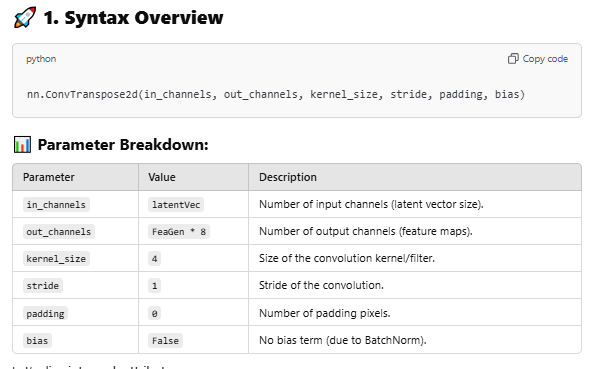

In [19]:
## Discriminator

class Discriminator(nn.Module):
    
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is channels x 64 x 64
            nn.Conv2d(channels, FeaDis, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (FeaDis) x 32 x 32
            nn.Conv2d(FeaDis, FeaDis * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaDis * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (FeaDis * 2) x 16 x 16
            nn.Conv2d(FeaDis * 2, FeaDis * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaDis * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (FeaDis * 4) x 8 x 8
            nn.Conv2d(FeaDis * 4, FeaDis * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaDis * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (FeaDis * 8) x 4 x 4
            nn.Conv2d(FeaDis * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.main(input)
    
    
# Create the discriminator
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


#### Loss functions and Optimizers

In [20]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, latentVec, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

#### Model training

In [21]:
# Lists to keep track of progress
Glosses = []
Dlosses = []
iters = 0
num_epochs = 5000

# For each epoch
for epoch in range(num_epochs):
    # For each batch in dataloader
    for i, data in enumerate(train_loader, 0):
        
        # Ensure the input to the discriminator is 4D (batch_size, channels, height, width)
        realImg = data[0].to(device)
        
        # Ensure the batch dimension is added (if missing)
        if realImg.dim() == 3:
            realImg = realImg.unsqueeze(0)  # Add batch dimension if it's missing
        
        batch_size = realImg.size(0)
        labels = torch.full((batch_size,), real_label, device=device).float()  # Convert labels to float
        
        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        
        # Forward pass through the discriminator for real images
        output = netD(realImg).view(-1)  # Flatten to 1D vector
        Real_Loss = criterion(output, labels)  # Calculate loss for real images
        Real_Loss.backward()  # Calculate gradient
        Dx = output.mean().item()  # Monitoring D(x) for real images
        
        ## Train with fake batch
        # Generate batch of latent vectors for the generator input
        noise = torch.randn(batch_size, latentVec, 1, 1, device=device)
        fake = netG(noise)  # Generate fake images
        labels.fill_(fake_label)  # Set labels for fake images
        labels = labels.float()  # Convert fake labels to float
        
        # Forward pass through D with detached fake images
        output = netD(fake.detach()).view(-1)  # Flatten to 1D vector
        Fake_Loss = criterion(output, labels)  # Calculate loss for fake images
        Fake_Loss.backward()  # Calculate gradient
        D_G1 = output.mean().item()  # Monitoring D(G(z)) for fake images
        
        # Add the gradients from the all-real and all-fake batches
        DisLoss = Real_Loss + Fake_Loss
        optimizerD.step()  # Update the discriminator's weights
        
        # Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        labels.fill_(real_label)  # Fake labels are treated as real for the generator
        output = netD(fake).view(-1)  # Flatten to 1D vector for generator loss
        GLoss = criterion(output, labels)  # Calculate generator loss
        GLoss.backward()  # Calculate gradient for the generator
        D_G2 = output.mean().item()  # Monitoring D(G(z)) after update
        optimizerG.step()  # Update the generator's weights
        
        # Output training stats
        if iters % 60 == 0:
            print('[Epoch %d/%d] [Batch %d/%d] [D Loss: %.4f] [G Loss: %.4f] [D(x): %.4f] [D(G(z)): %.4f/%.4f]' 
                  % (epoch, num_epochs, i, len(train_loader), DisLoss.item(), GLoss.item(), Dx, D_G1, D_G2))
            
            # Save generated image for monitoring
            ValidImage = netG(fixed_noise)
        
        iters += 1
            
        # Save Losses for plotting or analysis
        Glosses.append(GLoss.item())
        Dlosses.append(DisLoss.item())


[Epoch 0/5000] [Batch 0/38] [D Loss: 1.9727] [G Loss: 14.3608] [D(x): 0.2283] [D(G(z)): 0.3909/0.0000]
[Epoch 1/5000] [Batch 22/38] [D Loss: 0.0315] [G Loss: 7.5060] [D(x): 1.0000] [D(G(z)): 0.0310/0.0005]
[Epoch 3/5000] [Batch 6/38] [D Loss: 0.0000] [G Loss: 27.7856] [D(x): 1.0000] [D(G(z)): 0.0000/0.0000]
[Epoch 4/5000] [Batch 28/38] [D Loss: 0.0000] [G Loss: 35.1365] [D(x): 1.0000] [D(G(z)): 0.0000/0.0000]
[Epoch 6/5000] [Batch 12/38] [D Loss: 0.0000] [G Loss: 41.2830] [D(x): 1.0000] [D(G(z)): 0.0000/0.0000]
[Epoch 7/5000] [Batch 34/38] [D Loss: 0.0000] [G Loss: 41.5860] [D(x): 1.0000] [D(G(z)): 0.0000/0.0000]
[Epoch 9/5000] [Batch 18/38] [D Loss: 0.0110] [G Loss: 25.5633] [D(x): 0.9891] [D(G(z)): 0.0000/0.0000]
[Epoch 11/5000] [Batch 2/38] [D Loss: 0.0000] [G Loss: 33.5736] [D(x): 1.0000] [D(G(z)): 0.0000/0.0000]
[Epoch 12/5000] [Batch 24/38] [D Loss: 0.0076] [G Loss: 5.4331] [D(x): 0.9989] [D(G(z)): 0.0064/0.0044]
[Epoch 14/5000] [Batch 8/38] [D Loss: 0.0032] [G Loss: 6.6975] [D(x

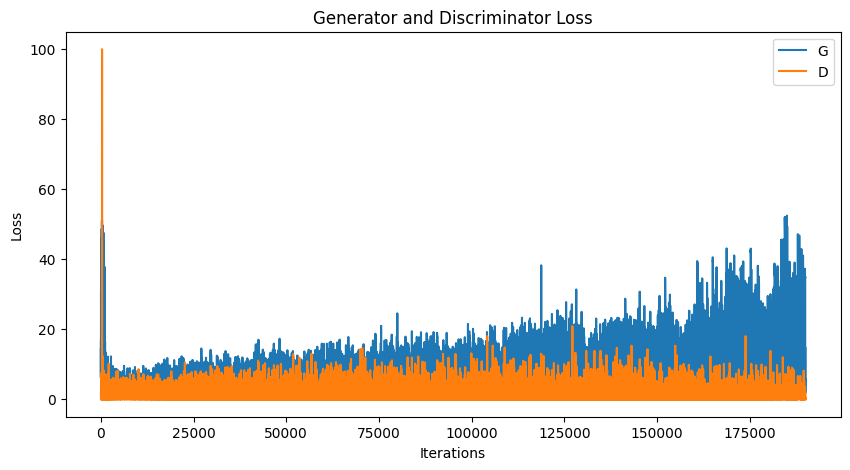

In [22]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(Glosses,label="G")
plt.plot(Dlosses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

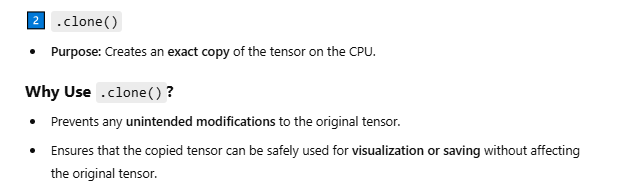

In [23]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()#clone copy a version of the tensor
    #detach remove the tensor from the computional graph
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

'e:\\CGAN\\images.zip'

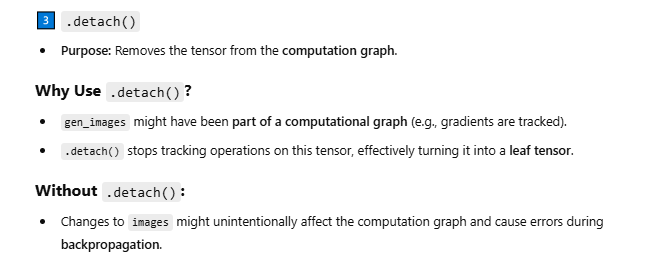

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


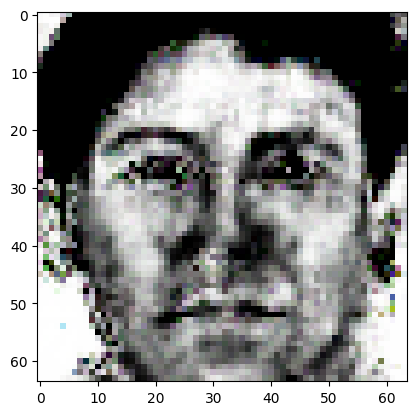

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


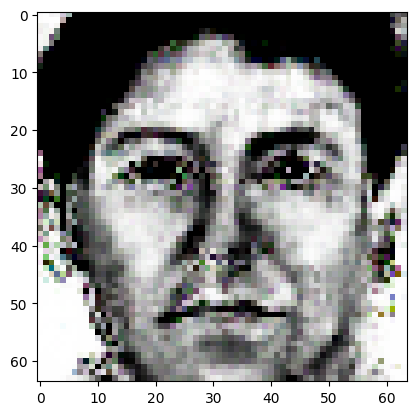

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


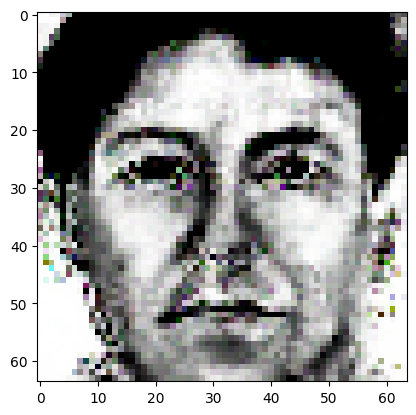

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


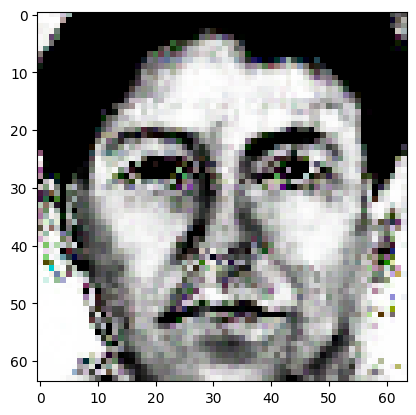

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


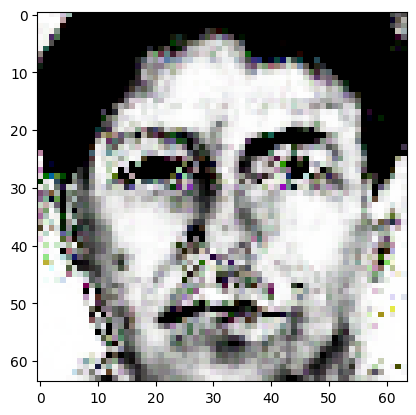

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


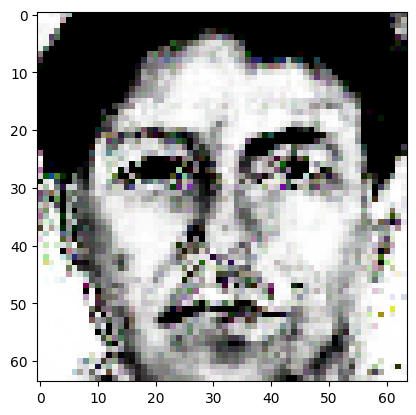

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


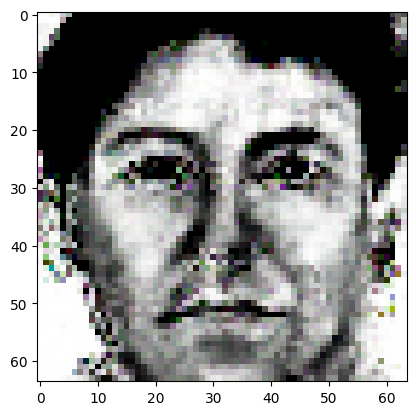

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


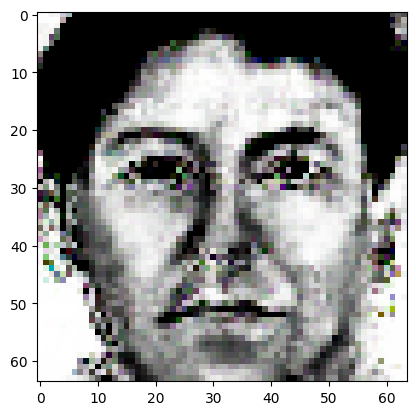

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


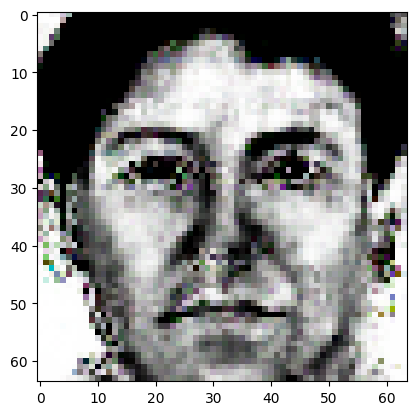

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


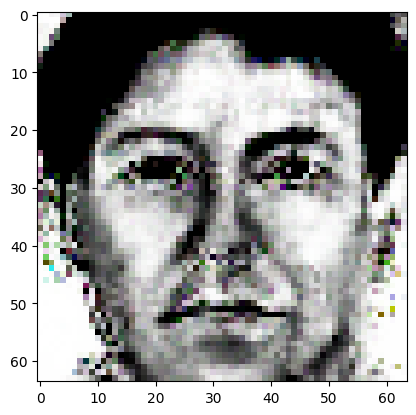

In [24]:
for i in range(10):
    plt.imshow(images[i])
    plt.show()


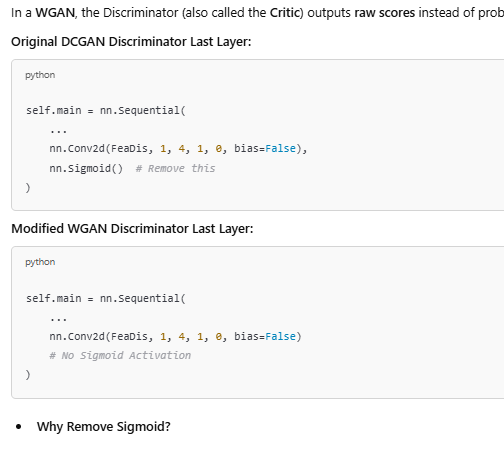

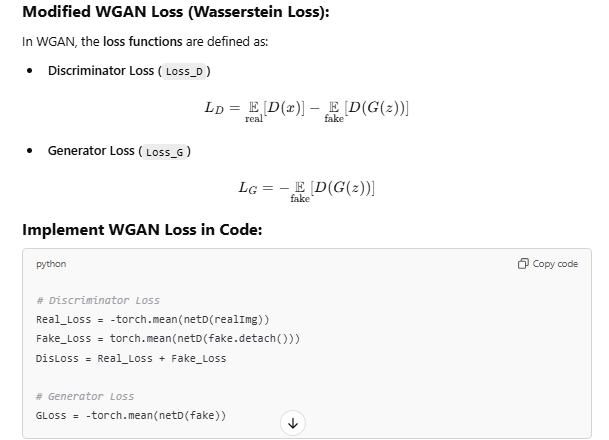

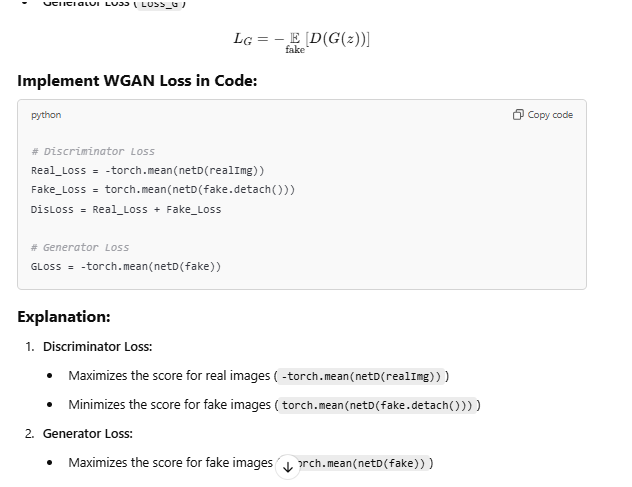

WGAN

In [25]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latentVec, FeaGen * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(FeaGen * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(FeaGen * 8, FeaGen * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaGen * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(FeaGen * 4, FeaGen * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaGen * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(FeaGen * 2, FeaGen, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaGen),
            nn.ReLU(True),
            nn.ConvTranspose2d(FeaGen, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [26]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(channels, FeaDis, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(FeaDis, FeaDis * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaDis * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(FeaDis * 2, FeaDis * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaDis * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(FeaDis * 4, FeaDis * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaDis * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(FeaDis * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1)


In [27]:
# Lists to keep track of progress
Glosses = []
Dlosses = []
iters = 0
num_epochs = 5000
critic_iterations = 5  # Number of critic updates per generator update
weight_clip = 0.01  # Weight clipping range

# Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        # Load real images and ensure correct dimensions
        realImg = data[0].to(device)
        if realImg.dim() == 3:
            realImg = realImg.unsqueeze(0)  # Add batch dimension if missing

        batch_size = realImg.size(0)
        
        # Update Critic (Discriminator) multiple times
        for _ in range(critic_iterations):
            netD.zero_grad()

            # Forward pass for real images
            output_real = netD(realImg).view(-1)
            D_real_loss = -torch.mean(output_real)  # Wasserstein loss for real images

            # Generate fake images
            noise = torch.randn(batch_size, latentVec, 1, 1, device=device)
            fake = netG(noise)

            # Forward pass for fake images
            output_fake = netD(fake.detach()).view(-1)
            D_fake_loss = torch.mean(output_fake)  # Wasserstein loss for fake images

            # Total critic loss
            CriticLoss = D_real_loss + D_fake_loss
            CriticLoss.backward()
            optimizerD.step()

            # Weight clipping
            for param in netD.parameters():
                param.data.clamp_(-weight_clip, weight_clip)
        
        # Save discriminator loss for analysis
        Dlosses.append(CriticLoss.item())

        # Update Generator
        netG.zero_grad()
        noise = torch.randn(batch_size, latentVec, 1, 1, device=device)
        fake = netG(noise)

        # Generator loss (maximize D(G(z)))
        output = netD(fake).view(-1)
        GLoss = -torch.mean(output)  # Wasserstein generator loss
        GLoss.backward()
        optimizerG.step()

        # Save generator loss for analysis
        Glosses.append(GLoss.item())

        # Output training stats every 60 iterations
        if iters % 100 == 0:
            print('[Epoch %d/%d] [Batch %d/%d] [Critic Loss: %.4f] [Generator Loss: %.4f]'
                  % (epoch, num_epochs, i, len(train_loader), CriticLoss.item(), GLoss.item()))
            
            # Save generated image for monitoring
            ValidImage = netG(fixed_noise)

        iters += 1


[Epoch 0/5000] [Batch 0/38] [Critic Loss: -0.0003] [Generator Loss: -0.5132]
[Epoch 2/5000] [Batch 24/38] [Critic Loss: -0.0348] [Generator Loss: -0.4820]
[Epoch 5/5000] [Batch 10/38] [Critic Loss: -0.1794] [Generator Loss: -0.3952]
[Epoch 7/5000] [Batch 34/38] [Critic Loss: -0.2483] [Generator Loss: -0.3552]
[Epoch 10/5000] [Batch 20/38] [Critic Loss: -0.3038] [Generator Loss: -0.3281]
[Epoch 13/5000] [Batch 6/38] [Critic Loss: -0.3294] [Generator Loss: -0.3140]
[Epoch 15/5000] [Batch 30/38] [Critic Loss: -0.3394] [Generator Loss: -0.3086]
[Epoch 18/5000] [Batch 16/38] [Critic Loss: -0.3436] [Generator Loss: -0.3076]
[Epoch 21/5000] [Batch 2/38] [Critic Loss: -0.3446] [Generator Loss: -0.3073]
[Epoch 23/5000] [Batch 26/38] [Critic Loss: -0.3444] [Generator Loss: -0.3071]
[Epoch 26/5000] [Batch 12/38] [Critic Loss: -0.3459] [Generator Loss: -0.3067]
[Epoch 28/5000] [Batch 36/38] [Critic Loss: -0.3465] [Generator Loss: -0.3065]
[Epoch 31/5000] [Batch 22/38] [Critic Loss: -0.3470] [Gener

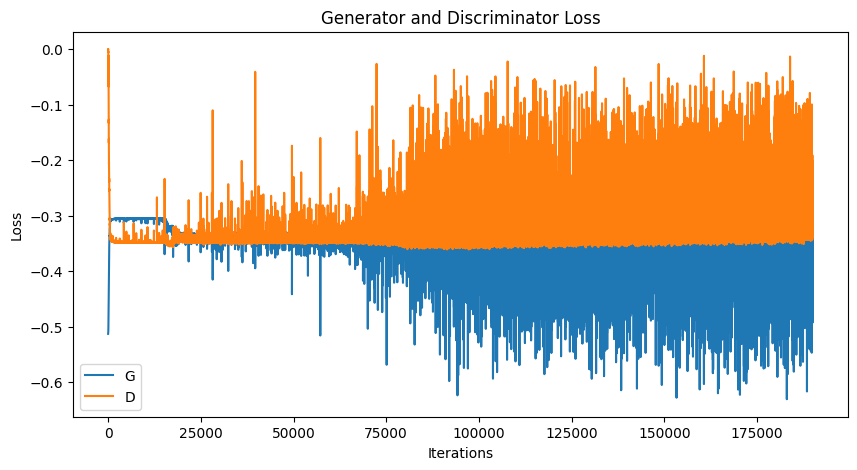

In [28]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(Glosses,label="G")
plt.plot(Dlosses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [29]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()#clone copy a version of the tensor
    #detach remove the tensor from the computional graph
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images2', 'zip', '../output_images')

'e:\\CGAN\\images2.zip'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


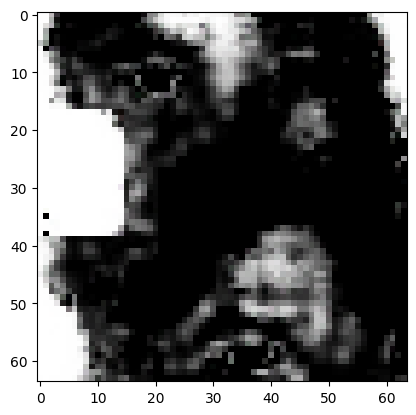

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


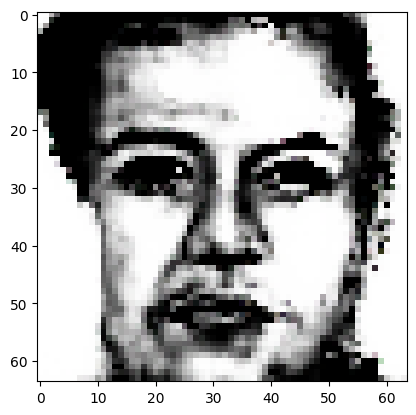

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


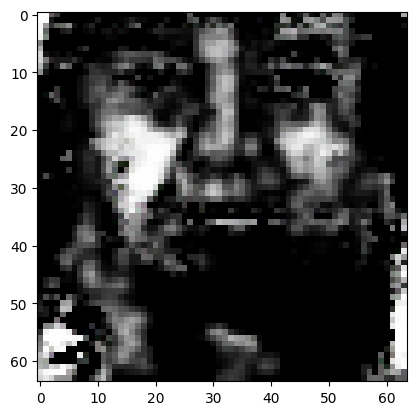

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


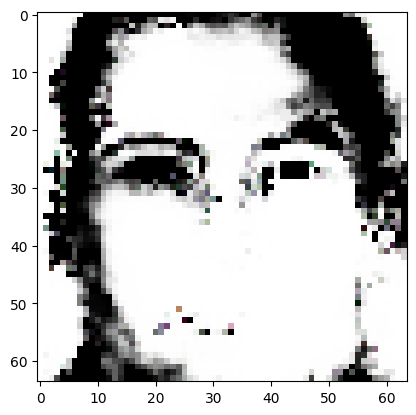

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


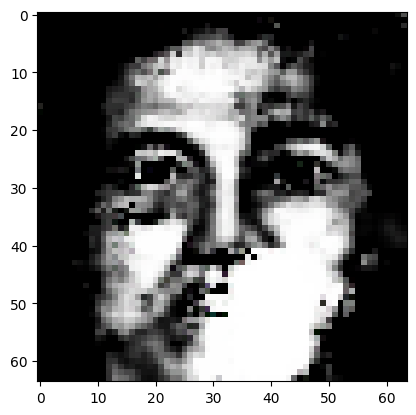

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


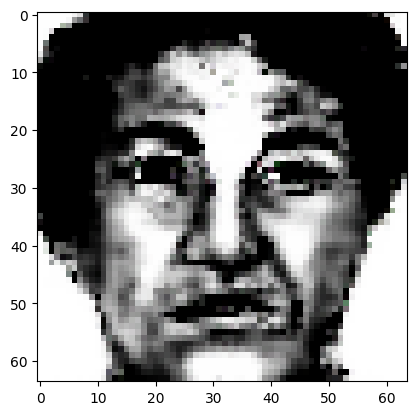

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


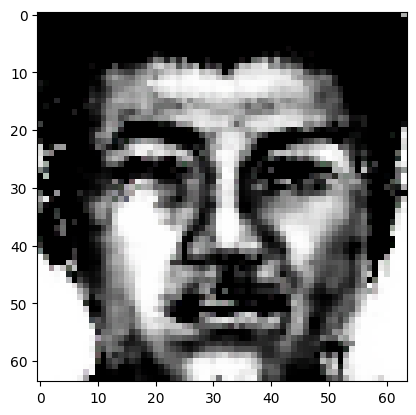

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


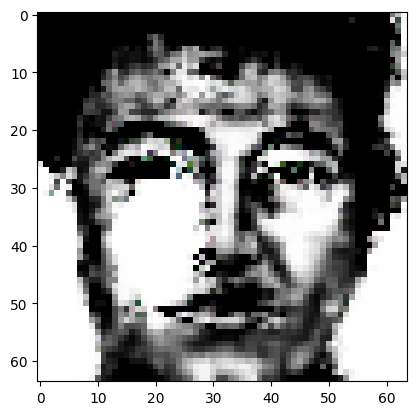

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


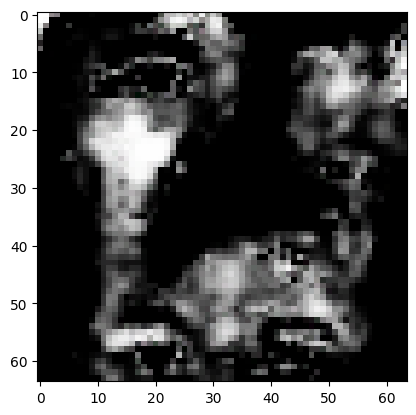

In [30]:
for i in range(40,49):
    plt.imshow(images[i])
    plt.show()


VAE

[Epoch 0/5000] [Batch 0/38] [Total Loss: 296167.0938] [Recon Loss: 295614.1875] [KL Loss: 552.8948]
[Epoch 1/5000] [Batch 0/38] [Total Loss: 64410.0391] [Recon Loss: 57955.7422] [KL Loss: 6454.2949]
[Epoch 2/5000] [Batch 0/38] [Total Loss: 40462.2578] [Recon Loss: 35004.5820] [KL Loss: 5457.6738]
[Epoch 3/5000] [Batch 0/38] [Total Loss: 36201.1719] [Recon Loss: 30970.7891] [KL Loss: 5230.3828]
[Epoch 4/5000] [Batch 0/38] [Total Loss: 33891.5664] [Recon Loss: 29543.8145] [KL Loss: 4347.7529]
[Epoch 5/5000] [Batch 0/38] [Total Loss: 33337.0508] [Recon Loss: 27962.2695] [KL Loss: 5374.7827]
[Epoch 6/5000] [Batch 0/38] [Total Loss: 31622.5820] [Recon Loss: 27100.1602] [KL Loss: 4522.4214]
[Epoch 7/5000] [Batch 0/38] [Total Loss: 30684.5410] [Recon Loss: 25879.9062] [KL Loss: 4804.6348]
[Epoch 8/5000] [Batch 0/38] [Total Loss: 28975.7422] [Recon Loss: 24465.4766] [KL Loss: 4510.2666]
[Epoch 9/5000] [Batch 0/38] [Total Loss: 28764.5488] [Recon Loss: 24578.0508] [KL Loss: 4186.4976]
[Epoch 10

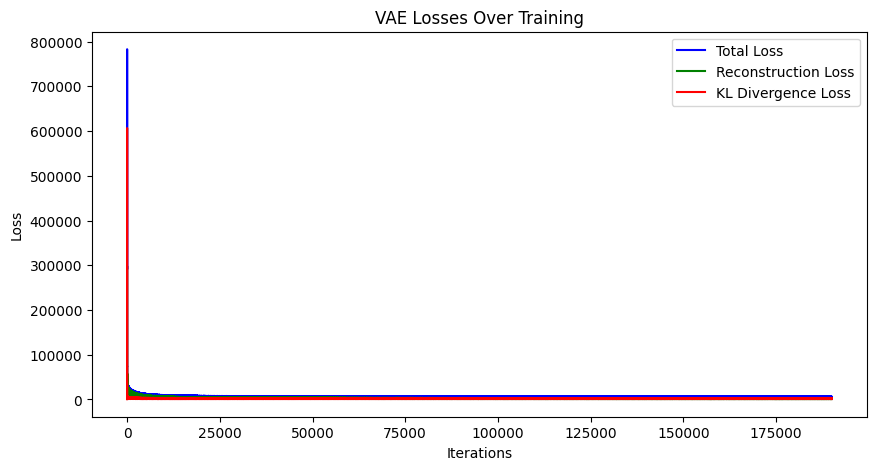

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
latentVec = 128  # Size of the latent vector
FeaDis = 64  # Feature size for the discriminator
FeaGen = 64  # Feature size for the generator
channels = 3  # For RGB images (3 channels)
num_epochs = 5000
batch_size = 32  # You can adjust as per your requirement

# Decide which device to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Encoder (VAE Encoder)
class Encoder(nn.Module):
    def __init__(self, latentVec, channels, FeaDis, ngpu):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(channels, FeaDis, 4, 2, 1, bias=False),  # Adjusted for RGB
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(FeaDis, FeaDis * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaDis * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(FeaDis * 2, FeaDis * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaDis * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(FeaDis * 4, FeaDis * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaDis * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc_mu = nn.Linear(FeaDis * 8 * 4 * 4, latentVec)
        self.fc_logvar = nn.Linear(FeaDis * 8 * 4 * 4, latentVec)

    def forward(self, x):
        x = self.main(x)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, FeaDis*8*4*4)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Define the Decoder (VAE Decoder)
class Decoder(nn.Module):
    def __init__(self, latentVec, channels, FeaGen, ngpu):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latentVec, FeaGen * 8 * 4 * 4)  # Adjust input size based on latentVec
        self.main = nn.Sequential(
            nn.ConvTranspose2d(FeaGen * 8, FeaGen * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaGen * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(FeaGen * 4, FeaGen * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaGen * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(FeaGen * 2, FeaGen, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FeaGen),
            nn.ReLU(True),
            nn.ConvTranspose2d(FeaGen, channels, 4, 2, 1, bias=False),  # Adjusted for RGB
            nn.Tanh()
        )

    def forward(self, z):
        z = self.fc(z)  # Pass through the fully connected layer
        z = z.view(z.size(0), -1, 4, 4)  # Reshape to match input to the conv layers
        return self.main(z)

# Define the VAE model (Encoder + Decoder)
class VAE(nn.Module):
    def __init__(self, latentVec, channels, FeaDis, FeaGen, ngpu):
        super(VAE, self).__init__()
        self.encoder = Encoder(latentVec, channels, FeaDis, ngpu)
        self.decoder = Decoder(latentVec, channels, FeaGen, ngpu)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

# VAE loss function (Reconstruction loss + KL Divergence)
def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss, kld_loss

# Training function
def train(vae, train_loader, optimizer, num_epochs=50):
    vae.train()
    
    # Lists to store the loss values for plotting
    recon_losses = []
    kld_losses = []
    total_losses = []
    
    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader, 0):
            realImg = data.to(device)
            vae.zero_grad()

            # Forward pass through VAE
            recon_batch, mu, logvar = vae(realImg)

            # Calculate loss
            recon_loss, kld_loss = vae_loss_function(recon_batch, realImg, mu, logvar)
            loss = recon_loss + kld_loss  # Total VAE loss is the sum of reconstruction loss and KL divergence
            loss.backward()
            optimizer.step()

            # Store the losses for plotting
            recon_losses.append(recon_loss.item())
            kld_losses.append(kld_loss.item())
            total_losses.append(loss.item())

            if i % 60 == 0:
                print(f'[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] [Total Loss: {loss.item():.4f}] [Recon Loss: {recon_loss.item():.4f}] [KL Loss: {kld_loss.item():.4f}]')

    # Plot the losses after training completes
    plt.figure(figsize=(10, 5))
    plt.title("VAE Losses Over Training")
    plt.plot(total_losses, label="Total Loss", color='blue')
    plt.plot(recon_losses, label="Reconstruction Loss", color='green')
    plt.plot(kld_losses, label="KL Divergence Loss", color='red')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Initialize VAE and Optimizer
vae = VAE(latentVec=latentVec, channels=channels, FeaDis=FeaDis, FeaGen=FeaGen, ngpu=1).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Assuming your `train_loader` is already set with the custom dataset
# Train the model
train(vae, train_loader, optimizer, num_epochs=5000)


In [32]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()#clone copy a version of the tensor
    #detach remove the tensor from the computional graph
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images3', 'zip', '../output_images')

'e:\\CGAN\\images3.zip'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


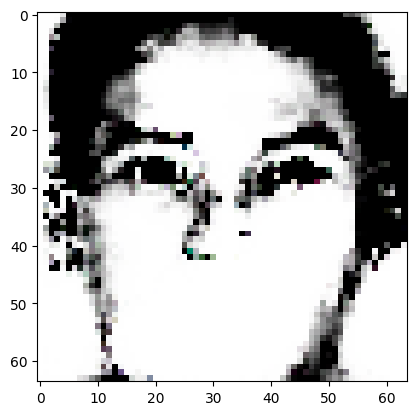

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


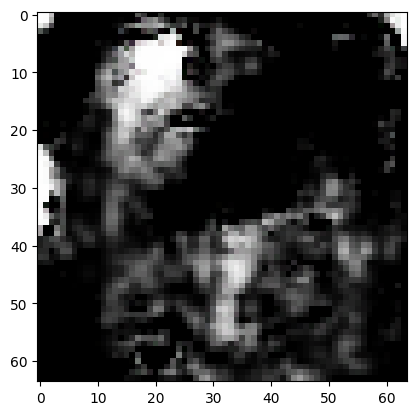

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


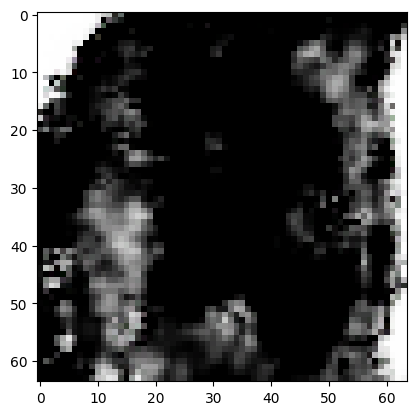

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


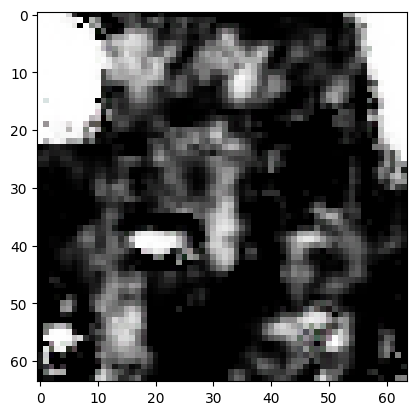

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


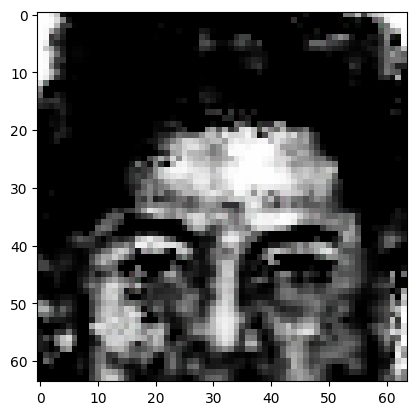

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


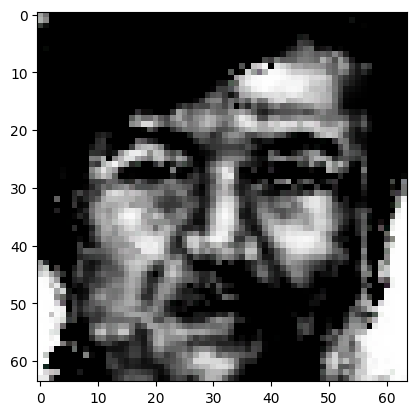

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


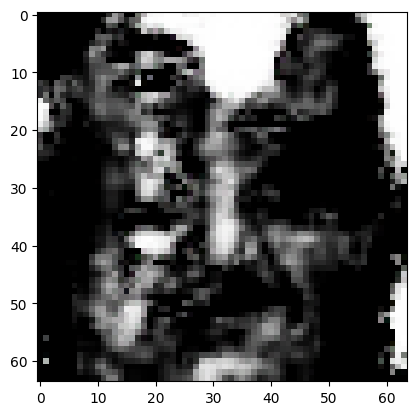

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


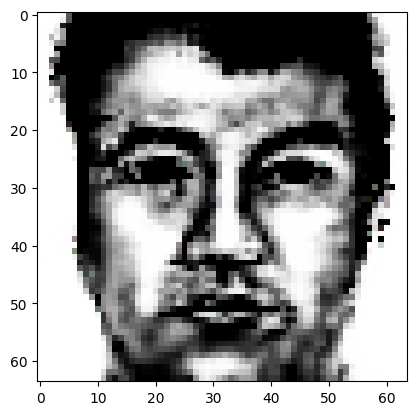

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


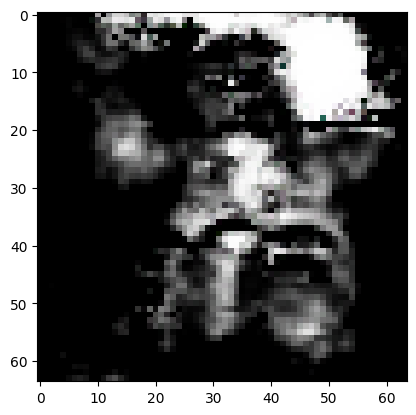

In [33]:
for i in range(40,49):
    plt.imshow(images[i])
    plt.show()
